# Introduction

- 5 layer CNN 
- keras API 
- gpu 확인

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # conver to one-hot-encoding
from keras.models import Sequential
from keras.layers import Convolution2D as Conv2D
from keras.layers import Dense, Dropout, Flatten, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Data preparation
## Load Data

In [6]:
train = pd.read_csv('/Users/rosaria/Desktop/data/digit/train.csv')
test = pd.read_csv('/Users/rosaria/Desktop/data/digit/test.csv')

In [19]:
Y_train = train['label']
X_train = train.drop(['label'], axis=1)

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

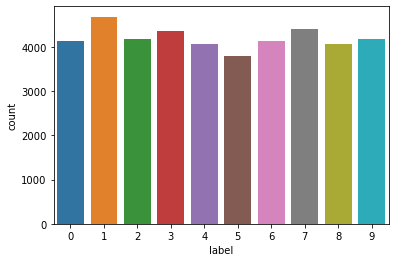

In [22]:
# Y frequency
del train

g = sns.countplot(Y_train)
Y_train.value_counts()

In [29]:
# NA
print(X_train.isnull().any().describe())
print(test.isnull().any().describe())

count       784
unique        1
top       False
freq        784
dtype: object

In [31]:
# Normalization
X_train = X_train/255.0
test = test/255

In [32]:
# Reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [38]:
#Labeling
Y_train = to_categorical(Y_train, num_classes=10)

In [40]:
#Split
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=random_seed)

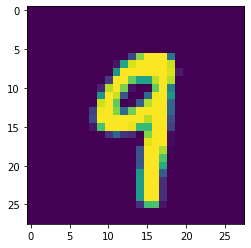

In [51]:
plt.imshow(X_train[2][:,:,0])

In [47]:
X_train[2][:,1:,0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.    

# CNN
- CNN: isolate features
- MaxPool2D: downsampling, reduce overfitting

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the images.

- Dropout
- Flatten later: convert the final feature maps into a one single 1D vector, combines all the found local features of the previous convolutional layers

In [56]:
# Model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [57]:
# Optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [58]:
# Compile
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
# learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                           patienve=3,
                                           verbos=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [60]:
epochs = 1
batch_size = 86

## Data augmentation

In [86]:
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=10,
                            zoom_range=0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,
                            vertical_flip=False)
datagen.fit(X_train)

In [87]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                             epochs=epochs,
                             validation_data=(X_val, Y_val),
                              verbose=2,
                              steps_per_epoch=X_train.shape[0]//batch_size,
                              callbacks=[learning_rate_reduction])

439/439 - 80s - loss: 0.0813 - accuracy: 0.9754 - val_loss: 0.0392 - val_accuracy: 0.9886


# Evaluate

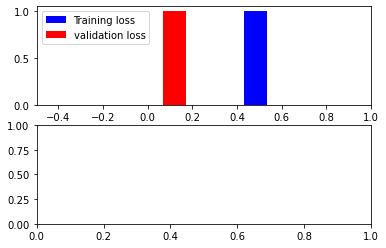

In [75]:
fig, ax = plt.subplots(2,1)
ax[0].hist(history.history['loss'], color='b', label='Training loss')
ax[0].hist(history.history['val_loss'], color='r', label='validation loss', axes=ax[0])
legend = ax[0].legend(loc='best')

In [81]:
history